In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv('../input/sbermarketdata/train.csv')
test = pd.read_csv('../input/sbermarketdata/sample_submission.csv')
DEBUG = 0
if DEBUG == 1:
    df = df.loc[1:1000]

df.head()

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


In [3]:
test.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


**Преобразуем тестовый набор данных в удобный для дальшейней работы вид**

In [4]:
df['order_completed_at'] = pd.to_datetime(df['order_completed_at'], format = '%Y-%m-%d %H:%M:%S')
#test preproc
df_test = test['id'].str.split(pat =';',expand = True)
df_test['order_completed_at']  = pd.Timestamp('2020-09-04 22:45:00')
df_test = pd.concat([df_test, test.iloc[:,-1]],axis = 1)
df_test = df_test.rename(columns = {0:'user_id',1:'cart'})
df_test['user_id'] = df_test['user_id'].astype('int')
df_test['cart'] = df_test['cart'].astype('int')
df_test.head()

,user_id,cart,order_completed_at,target
0,0,133,2020-09-04 22:45:00,0
1,0,5,2020-09-04 22:45:00,1
2,0,10,2020-09-04 22:45:00,0
3,0,396,2020-09-04 22:45:00,1
4,0,14,2020-09-04 22:45:00,0


**Последняя дата совершения покупки в наборе данных**

In [5]:
df.order_completed_at.max()

Timestamp('2020-09-03 23:45:45')

**Посмотрим, сколько уникальных значений содержит в себе набор данных**

In [7]:
# SKOKA NE UNIQUE
Unique_users = len(np.unique(df.user_id))
Unique_carts = len(np.unique(df.cart))
Unique_dates = len(np.unique(df.order_completed_at))
print('Уникальное количество покупателей в тестовом наборе данных: {0} '.format(Unique_users))
print('Уникальное количество товаров в тестовом наборе данных: {0}'.format(Unique_carts))
print('Уникальное количество дат покупки в тестовом наборе данных: {0}'.format(Unique_dates))

Уникальное количество покупателей в тестовом наборе данных: 20000 
Уникальное количество товаров в тестовом наборе данных: 881
Уникальное количество дат покупки в тестовом наборе данных: 208155


**Для того чтобы наш классификатор смог качественно отличать метки, требуется создать к каждому заказу список из товаров, которые пользователь не приобрел.**

In [8]:
df.sort_values(by=['user_id','order_completed_at'], inplace = True)
id_orders = df.groupby(['user_id', 'order_completed_at']).cart
user_id = 0
carts = []
cart_every_order = []
count_cart = []
orders = []
for Id, date in id_orders:
    if user_id == Id[0]:
        carts.extend(list(date))
        orders.append(list(set(carts))[:])
    else:
        carts = []
        carts.extend(list(date))
        orders.append(list(set(carts))[:])
    user_id = Id[0]
    cart_every_order.append(list(date))
    count_cart.append(len(date))
            
not_this_ord_cart = []
for cart, cart_now in zip(orders,cart_every_order):
    not_this_ord_cart.append(list(set(cart) - set(cart_now)))

diff_carts = np.zeros((len(not_this_ord_cart)))
for i, product, in enumerate(not_this_ord_cart):
    diff_carts[i] = len(product)

In [9]:
id_orders = df.groupby(['user_id', 'order_completed_at']).size()
id_orders = id_orders.to_frame().reset_index()
ids = id_orders.user_id.to_numpy()
dates = id_orders.order_completed_at.to_numpy()

In [10]:
part1_df = {'user_id': np.repeat(ids, diff_carts.astype('int')), 
               'order_completed_at': np.repeat(dates, diff_carts.astype('int')),
               'cart': list(itertools.chain.from_iterable(not_this_ord_cart) ), #i for i in not_this_ord_cart
               'order_vol': np.repeat(count_cart, diff_carts.astype('int'))} 
part1_df = pd.DataFrame(data=part1_df)
part1_df['target'] = 0
df.sort_values(by=['user_id','order_completed_at'], inplace = True)
df['order_vol']= np.repeat(count_cart, count_cart)
df['target'] = 1

# **EDA**

**Для начала посмотрим сколько людей какое количество заказов совершило. Это может помочь при создании признаков, таких как среднее количество заказов у пользователя, а также вычисление каких-либо оконных функций.**

In [11]:
#1. Сколько людей сколько сделали заказов
df_eda = df.sort_values(by = ['user_id','order_completed_at'])
order_number = df_eda.groupby('user_id')['order_completed_at'].apply(lambda x: LabelEncoder().fit_transform(x)).explode()
order_number.reset_index(drop=True, inplace = True)
order_number.rename('order_num', inplace = True)
df_eda.reset_index(drop=True, inplace = True)
df_eda = pd.concat([df_eda, order_number], axis=1)
df_eda.order_num += 1
df_eda.sort_values(by=['order_completed_at'], inplace = True)
users_per_order = df_eda.groupby(['user_id','order_num']).size().to_frame()
users_per_order.reset_index(inplace = True)
users_per_order['order_num'].value_counts().to_frame().head(20)

,order_num
1,20000
3,20000
2,20000
4,15962
5,13229
6,11203
7,9680
8,8451
9,7436
10,6601


**Очевидно, что большие заказы делают меньшее количество пользователей. Посмотрим, зависит ли корзина покупателя в от присутствия в ней самого популярного заказа. В случае если самый популярный товар присутствует как в одиночных заказах, так и в заказах с большим количеством товаров, то оценивать средний размер корзины пользователя за n-дней особого смысла нет, ведь он может просто отдельно заказать его, или же вместе с другими**

In [12]:
n = max((np.unique(df.cart)))
most_frq_carts = df_eda['cart'].value_counts()[:n].to_frame()
most_frq_carts.head()

,cart
57,108877
14,93957
61,91543
398,81694
23,71837


**Как можно видеть, популярных заказов много, однако присутствуют и те, которые заказали всего 1 раз.**

In [13]:
xtt = df.loc[df.cart == 57]
MaxBucket = np.max(xtt.order_vol)
MinBucket = np.min(xtt.order_vol)
print('Максимальное количество товаров в заказе с участием самого популярного товара: {}'.format(MaxBucket))
print('Минимальное количество товаров в заказе с участием самого популярного товара: {}'.format(MinBucket))

Максимальное количество товаров в заказе с участием самого популярного товара: 120
Минимальное количество товаров в заказе с участием самого популярного товара: 1


**Отсюда можно сделать вывод, что среднее за n дней использовать в качестве признака особого смысла нет, более того, некоторые люди заказывают намного реже чем, допустим, 7 дней. Тогда данный признак не имеет смысла. Более того, дата покупки в следующий момент времени не задана, поэтому адекватное вычисление сренего за некий промежуток времени.**

In [14]:
#3. Может быть стоит удалить некоторые товары, которые ни разу не повторились для чистоты данных
No_repeated_carts = sum(most_frq_carts.cart == 1)
Proc = (No_repeated_carts/n)*100
print('Процент неповторяющихся товаров из всего списка товаров: {}%'.format(Proc))
SingleOrder = len(df.loc[df.order_vol == 1])
notSingleOrder = len(df.loc[df.order_vol != 1])
print('Отношение заказов с одним товаром к заказам, количество товаров которых более единицы: {}%'.format(100*(SingleOrder/notSingleOrder)))


Процент неповторяющихся товаров из всего списка товаров: 8.75%
Отношение заказов с одним товаром к заказам, количество товаров которых более единицы: 0.14307692998337074%


**Процент товаров которые заказали лишь один раз составляте почти 9 процетов. Достаточно много чтобы выбрасывать данный товар и всего набора данных. Также была проверена гипотеза о том, что если выбросить часть заказов, в которых всего 1 товар, качество предсказаний увеличится.(Спойлер: может быть и да, но у меня качество только ухудшилось). Аналогичным образом была проверена гипотеза о том, что выбросив те id которых нет в тестовом наборе из исходного, можно повысить качество предсказаний модели. Результат аналогичный предыдущей гипотезе**

In [ ]:
#df = df[~df['order_vol'].isin(order_diff)]
#df = df[~df['user_id'].isin(id_diff)]
#df = df[~df['cart'].isin(cart_diff)]

<AxesSubplot:xlabel='order_completed_at', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

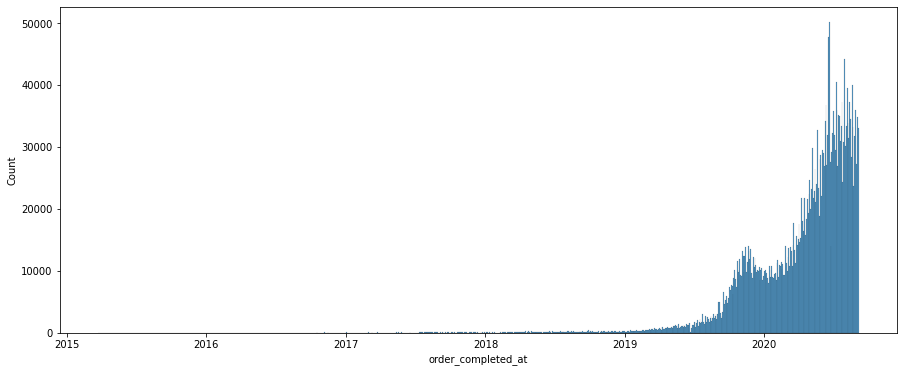

In [15]:
size = (15,6)
plt.figure()
fig, ax = plt.subplots(figsize=size) 
sns.histplot(df.order_completed_at)

**Виден явный всплеск после перехода inst->sber, было бы логично обучать модель исключительно после данного перегиба, однако скорее всего есть товары которые пользовались популярностью и до перехода.**

<AxesSubplot:xlabel='cart', ylabel='Count'>

<Figure size 432x288 with 0 Axes>

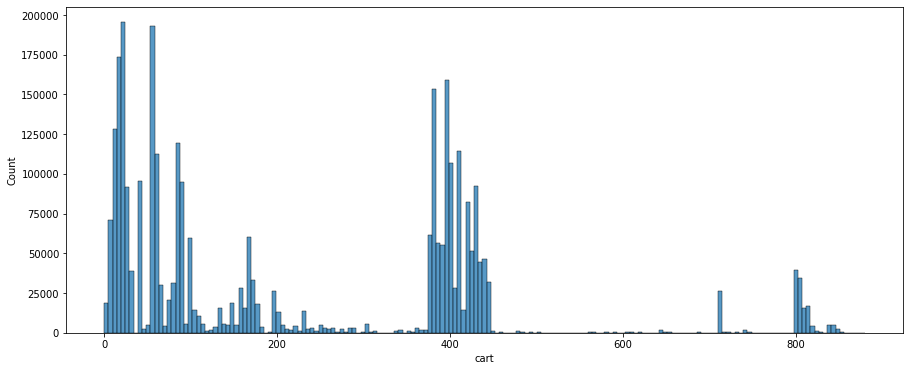

In [17]:
fig_dims = (15,6)
plt.figure()
fig, ax = plt.subplots(figsize=fig_dims)
sns.histplot(df.cart)

**Анализируя данный график, можно сделать вывод о том, что популярностью пользуется около 50% процентов всех товаров**

In [18]:
df = pd.concat([df_test, part1_df, df], ignore_index = True)
df.sort_values(by=['user_id','order_completed_at'], inplace = True)
df.head()

,user_id,cart,order_completed_at,target,order_vol
9839230,0,20,2020-07-19 09:59:17,1,8.0
9839231,0,82,2020-07-19 09:59:17,1,8.0
9839232,0,441,2020-07-19 09:59:17,1,8.0
9839233,0,57,2020-07-19 09:59:17,1,8.0
9839234,0,14,2020-07-19 09:59:17,1,8.0


# Feature Engineering

**При формировании признаков я делал упор на то, чтобы показать модели тенденции к заказу того или иного товара. Я отказался от скользящих окон, а также от различных вариаций признаков, показывающий повторный заказ, как бы это не выглядело странно. На кросс-валидации данные признаки показали худший вклад в работу модели.**


In [19]:
def add_feats(df):
    n = max((np.unique(df.cart)))
    most_frq_carts = df['cart'].value_counts()[:n].to_frame()
    dict_freq = most_frq_carts.cart.to_dict()
    copycart = df['cart'].copy()
    df['freq'] = copycart.replace(dict_freq)
    
    order_size = df.groupby(['user_id', 'order_completed_at']).order_vol.mean().to_frame()
    xt = order_size.groupby(['user_id','order_completed_at']).order_vol.count().to_frame()
    xtt = order_size/xt
    xtt_diff = xtt.diff()
    New_ord_diff = xtt_diff.groupby(['user_id']).order_vol.fillna(0).values.astype('float16')
    New_ord = xtt.groupby(['user_id']).order_vol.transform('mean').values
    arr_size = df.groupby(['user_id', 'order_completed_at']).size().values
    df['mean_order_size'] = np.repeat(New_ord, arr_size)
    df['mean_diff'] = np.repeat(New_ord_diff, arr_size)
    
    
    
    df.sort_values(by=['user_id', 'order_completed_at'], inplace = True)
    df['tmp'] = df.groupby(['user_id', 'cart'])['target'].cumsum()
    df['user_product_orders'] = df.groupby(['user_id', 'cart'])['tmp'].shift().astype('float16')  
    
    
    
    df.sort_values(by=['user_id','order_completed_at'], inplace = True)
    orders = df.groupby('user_id')['order_completed_at'].transform(lambda x: LabelEncoder().fit_transform(x)).explode()
    orders.reset_index(drop=True, inplace = True)
    orders.rename('orders', inplace = True)
    df.reset_index(drop=True, inplace = True)
    df['orders'] = orders
    df['order_num'] = df['orders'] + 1
    
    
    
    df['cumcount_orders'] = df.groupby(['cart']).cumcount()
    #df['cumcount_diff'] = df['cumcount_orders'].diff() На кросс-валидации лучше, на тесте хуже
    df.sort_values(by=['user_id','order_completed_at','cart'], inplace = True)
    df['tmpD'] = df['order_completed_at'].dt.date
    date_between_orders = df.groupby(['user_id','order_completed_at']).tmpD.unique().explode()
    date_between_orders = date_between_orders.groupby('user_id').diff() / 1.0 /np.timedelta64(1, 'D')
    df['date_between_orders'] = np.repeat(date_between_orders.values, arr_size)
    
  
    
    df['last_day_ordering'] = 0
    mask0 = df['target'] == 0
    mask1 = df['target'] == 1
    df.loc[ mask0 , 'last_day_ordering'] = df.loc[ mask0 , 'date_between_orders']
    df.loc[ mask0 , 'last_day_ordering'] = df.loc[ mask0 ].groupby(['user_id', 'cart']).last_day_ordering.cumsum()
    df['last_day_ordering'] = df.groupby(['user_id', 'cart']).last_day_ordering.shift()
    
    df.sort_values(by=['user_id','cart', 'order_completed_at'], inplace = True)
    df['streak'] = df.groupby(['user_id','cart',(df['target'] != df['target'].shift(1)).cumsum()]).cumcount()+1
    df['streak_zero'] = 0
    df['streak_ones'] = 0
    df.loc[ mask0 , 'streak_zero'] = df.loc[ mask0 , 'streak']
    df.loc[mask1 == 1, 'streak_ones'] = df.loc[mask1, 'streak']
    df['all_orders_diff_last_order'] = df.groupby(['user_id','cart']).streak_zero.shift()
    df['streak_zero'] = df.groupby(['user_id','cart']).streak_zero.cummax()
    df['streak_ones'] = df.groupby(['user_id','cart']).streak_ones.cummax()
    df['streak_zero'] = df.groupby(['user_id','cart']).streak_zero.shift()
    df['streak_ones'] = df.groupby(['user_id','cart']).streak_ones.shift()
    df.set_index(['order_completed_at'], inplace = True)
    df = df.sort_index()
    df = df.reset_index(level='order_completed_at')
    df.drop(['tmpD','tmp','streak','orders'],axis = 1,inplace = True)
    return df

In [20]:
df = add_feats(df)

**Посмотрим, что мы там нагенерировали. Возможно придется что-то удалить ввиду высокой корреляции.**

<AxesSubplot:>

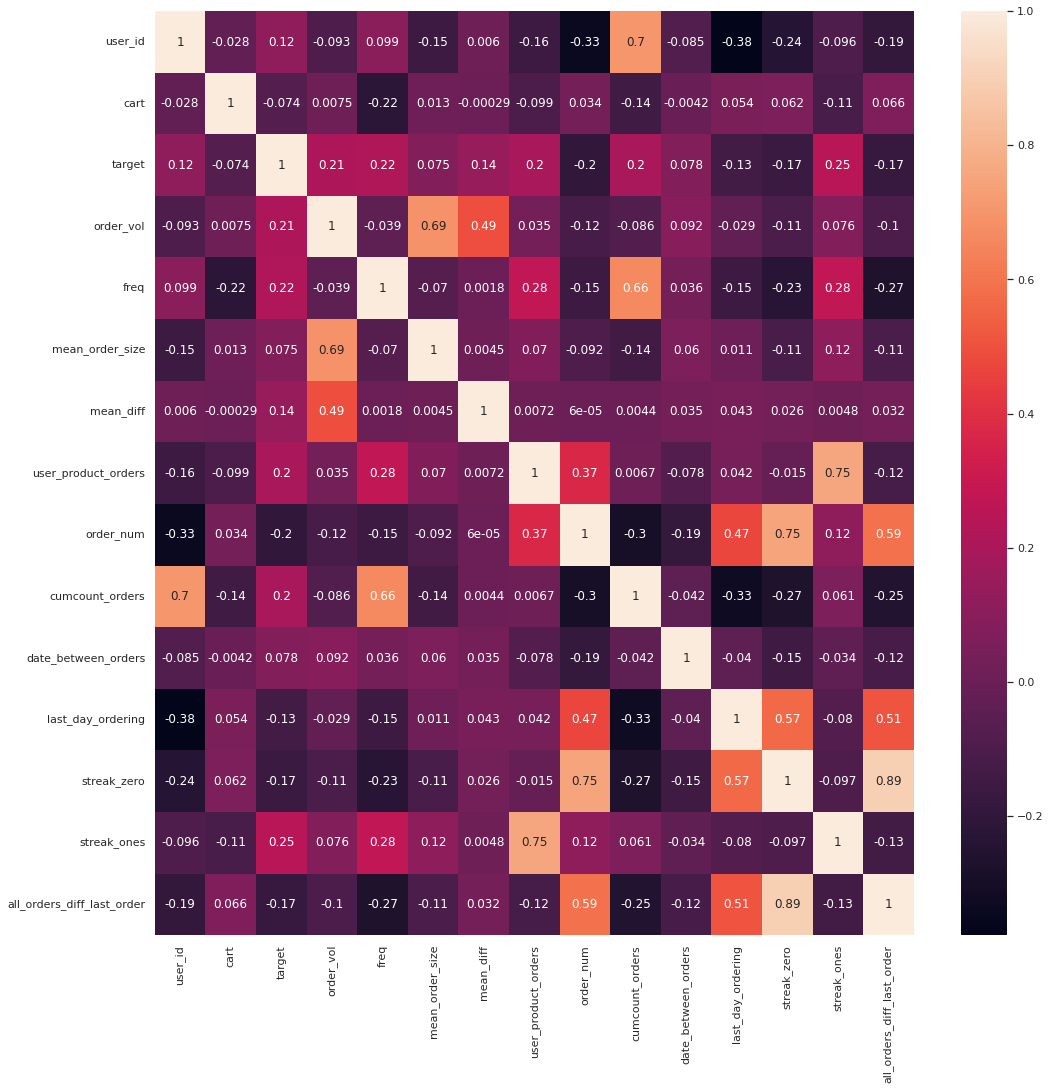

In [21]:
corr_coeffs = df.corr(method = 'pearson')
sns.set(rc={'figure.figsize':(17,17)})
sns.heatmap(corr_coeffs,annot=True)

**В целом все неплохо, однако если удалить streak_zero, качество будет хуже.**

In [22]:
df.sort_values(by=['order_completed_at'], inplace = True)
df.head()

,order_completed_at,user_id,cart,target,order_vol,freq,mean_order_size,mean_diff,user_product_orders,order_num,cumcount_orders,date_between_orders,last_day_ordering,streak_zero,streak_ones,all_orders_diff_last_order
0,2015-03-22 09:25:46,2,384,1,16.0,120415,11.466667,0.0,NaN,1,0,NaN,NaN,NaN,NaN,NaN
15,2015-03-22 09:25:46,2,198,1,16.0,98284,11.466667,0.0,NaN,1,0,NaN,NaN,NaN,NaN,NaN
14,2015-03-22 09:25:46,2,409,1,16.0,145936,11.466667,0.0,NaN,1,3,NaN,NaN,NaN,NaN,NaN
13,2015-03-22 09:25:46,2,425,1,16.0,116016,11.466667,0.0,NaN,1,0,NaN,NaN,NaN,NaN,NaN
11,2015-03-22 09:25:46,2,57,1,16.0,186836,11.466667,0.0,NaN,1,4,NaN,NaN,NaN,NaN,NaN


**Сформируем тестовый набор данных, с помощью которого будет формировать сабмит.**

In [23]:
df.sort_values(by=['order_completed_at'], inplace = True)
df_test = df[df.order_completed_at == '2020-09-04 22:45:00'].copy()
df_test.sort_values(by=['cart','order_completed_at', 'user_id'], inplace = True)
df_test.head()

,order_completed_at,user_id,cart,target,order_vol,freq,mean_order_size,mean_diff,user_product_orders,order_num,cumcount_orders,date_between_orders,last_day_ordering,streak_zero,streak_ones,all_orders_diff_last_order
12380107,2020-09-04 22:45:00,7,0,0,NaN,93564,8.636364,0.0,1.0,12,13,24.0,0.0,0.0,1.0,0.0
12380559,2020-09-04 22:45:00,8,0,1,NaN,93564,37.375000,0.0,1.0,9,22,16.0,288.0,7.0,1.0,7.0
12379438,2020-09-04 22:45:00,9,0,0,NaN,93564,8.021739,0.0,1.0,47,66,7.0,805.0,42.0,1.0,42.0
12381611,2020-09-04 22:45:00,12,0,1,NaN,93564,19.428571,0.0,2.0,22,86,8.0,0.0,17.0,1.0,0.0
12382327,2020-09-04 22:45:00,13,0,1,NaN,93564,18.882353,0.0,3.0,18,98,3.0,383.0,7.0,2.0,7.0


# Train, test and fit_predict

**Удалим все данные, которые содержат NaN, а также тестовые данные по временной метке**

In [24]:
df = df.dropna()
df = df.drop(df[df.order_completed_at == '2020-09-04 22:45:00'].index)

**Аналогично поступим с данными для обучения. Уберем время и целевую переменную, время мы уже закодировали.**

In [25]:
df.sort_values(by=['order_completed_at'], inplace = True)
X_train = df[df.columns.difference(['target','order_completed_at'])]
y_train = df.target
feats = X_train.columns

X_train.head()

,all_orders_diff_last_order,cart,cumcount_orders,date_between_orders,freq,last_day_ordering,mean_diff,mean_order_size,order_num,order_vol,streak_ones,streak_zero,user_id,user_product_orders
17,0.0,399,18,16.0,63755,0.0,0.0,8.857143,2,1.0,1.0,0.0,3,1.0
34,0.0,399,19,39.0,63755,0.0,1.0,8.857143,3,2.0,2.0,0.0,3,2.0
37,0.0,134,16,107.0,64868,0.0,-1.0,8.857143,4,1.0,1.0,0.0,3,1.0
38,1.0,399,20,107.0,63755,39.0,-1.0,8.857143,4,1.0,2.0,1.0,3,2.0
39,0.0,804,14,107.0,103618,0.0,-1.0,8.857143,4,1.0,1.0,0.0,3,1.0


In [26]:
sc =RobustScaler()
X_train = sc.fit_transform(X_train)

**Каггл почему-то лопается при попытке подобрать оптимальные параметры. Запустил на своем, результаты чуть ниже**

In [ ]:
#lgbm = LGBMClassifier(n_estimators = 250,random_state=42) 
#cv = TimeSeriesSplit(n_splits = 5)
#rs = 42
#param_lgbm = {
#    'learning_rate': optuna.distributions.UniformDistribution(0.005, 0.25),                   
#    'num_leaves': optuna.distributions.IntUniformDistribution(7, 120),   
#    'lambda_l2': optuna.distributions.IntUniformDistribution(0, 12),
#    'min_data_in_leaf': optuna.distributions.IntUniformDistribution(20, 1300),
#    'subsample': optuna.distributions.UniformDistribution(0.2 ,1.0),
#    'colsample_bytree': optuna.distributions.UniformDistribution(0.2, 1.0),  
#    'scale_pos_weight': optuna.distributions.IntUniformDistribution(1, 25) 
#    }

#optuna_search_lgbm = optuna.integration.OptunaSearchCV(lgbm, param_lgbm, n_trials=100, 
#                                                             random_state=42, n_jobs=-1, 
#                                                             cv = cv, scoring= 'f1')
#optuna_search_lgbm.fit(X_train, y_train)
#optuna_search_lgbm.best_params_

In [27]:
score = ['f1','roc_auc']
cv = TimeSeriesSplit(n_splits = 5)
rs = 42
lgbm = LGBMClassifier(n_estimators=250,random_state=rs) 
parameter = {'learning_rate': 0.07280792119523564,
 'num_leaves': 47,
 'lambda_l2': 2,
 'min_data_in_leaf': 830,
 'subsample': 0.8064350328469048,
 'colsample_bytree': 0.6281573812285622,
 'scale_pos_weight': 3}
lgbm.set_params(**parameter)

LGBMClassifier(colsample_bytree=0.6281573812285622, lambda_l2=2,
               learning_rate=0.07280792119523564, min_data_in_leaf=830,
               n_estimators=250, num_leaves=47, random_state=42,
               scale_pos_weight=3, subsample=0.8064350328469048)

**Проведем кросс-валидацию на обучающем наборе данных, в качестве метрики будет f1 и ROC AUC. Заодно посмотрим на важность признаков при принятии решений моделью.**

In [28]:
CV_model = cross_validate(lgbm, X_train, y_train, cv=cv, scoring = score, return_estimator =True)
print(CV_model['test_f1'])
for idx,estimator in enumerate(CV_model['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = feats,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)


[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830
[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[Lig

**Аналогично поступим с тестовыми данными, отбросим не нужные стобцы. Сделаем предсказания, далее оценим качество по метрике f1.**

In [29]:
X_test = df_test[df_test.columns.difference(['target','order_completed_at'])]
y_test = df_test.target
X_test = sc.transform(X_test)
lgbm.fit(X_train,y_train)
y_pred = lgbm.predict(X_test)


[LightGBM] [Warning] lambda_l2 is set=2, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2
[LightGBM] [Warning] min_data_in_leaf is set=830, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=830


In [30]:
f1_score(y_test, y_pred, average=None)

array([0.60413666, 0.32150975])

**Формирование файла сабмита**

In [31]:
df_test['user_id'] = df_test['user_id'].astype('str')
df_test['cart'] = df_test['cart'].astype('str')
df_test['id'] = df_test[['user_id', 'cart']].agg(';'.join, axis=1)
df_test['target'] = y_pred
df_test['target'] = df_test['target'].astype('int64')
subm = df_test[['id', 'target']]
subm.set_index(['id'], inplace = True)
subm.to_csv('another_one_sub.csv')

**Я потерял нормальный ноутбук с топовым скором по лб :(
Ниже выдержка по сабмитам и оценкам f1 метрики.**

In [32]:
#array([0.60433503, 0.32076286]) 0.48627
#array([0.60409969, 0.32139473]) 0.48622
#array([0.60402861, 0.32192932]) 0.48620
#array([0.61169226, 0.29865985]) 0.48615
#array([0.60443683, 0.32148028]) 0.48611
#array([0.61160523, 0.29807689]) 0.48455
#array([0.61112161, 0.29980974]) 0.48448
#array([0.6109087 , 0.30112243]) 0.48433